## Advertising Analytics

To understand the performance of a variety of advertisment groups we first calculate performance metrics, then we attempt to forecast the number of adds shown 3 weeks ahead. Finally we calculate the percent change in cost per click and cluster the ad groups accordingly. 

In [7]:
import pandas as pd
#ads = pd.read_csv("https://raw.githubusercontent.com/ishaojunzhang/ads/master/ad_table.csv")
ads = pd.read_csv("ad_table.csv")
import numpy as np

In [9]:
ads =ads[ads.columns[1:]]

## Question 1

If you had to identify the 5 best ad groups, which ones would they be? Which metric did you choose to identify the best ad groups? Why? Explain the pros of your metric as well as the possible cons.

We selected net profit, profit per click and average conversion rate as metrics to identify the best ad groups. 

## Net Profit:
Simple to calculate.  sum (total revenue - cost/click * clicked). Is good at differentiating between really strongly performing groups and poorly performing groups but a large profit may require a substantial revenue stream behind it. Additionally the data provided is only a sample and such a gross statistic may no be indicative of the general performance of a given group

## Profit Per Click:
After calculating the daily profit for each ad group we can calculate profit/click which provides a stronger indication of the unit benefit for increase in a given ad group. 

## Conversion Rate:
We calculate the number of conversion (number of interactions with our underlying product)/ (number of clicks). Despite not being directly focused on the profit this metrics is important because it determines our product success through user interests as well as gauging the efficacy of our advertisment. 

In [149]:
ads

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,profit
0,10/1/15,65877,2339,43,0.90,641.62,ad_group_1,-1463.48
1,10/2/15,65100,2498,38,0.94,756.37,ad_group_1,-1591.75
2,10/3/15,70658,2313,49,0.86,970.90,ad_group_1,-1018.28
3,10/4/15,69809,2833,51,1.01,907.39,ad_group_1,-1953.94
4,10/5/15,68186,2696,41,1.00,879.45,ad_group_1,-1816.55
...,...,...,...,...,...,...,...,...
2110,11/18/15,78111,1326,37,1.01,553.36,ad_group_40,-785.90
2111,11/19/15,79857,1413,34,1.00,840.72,ad_group_40,-572.28
2112,11/20/15,75695,1332,35,1.09,468.95,ad_group_40,-982.93
2113,11/21/15,73761,1336,36,1.11,437.03,ad_group_40,-1045.93


In [108]:
def calculate_ad_metrics(df):
    #calculate net profit
    profit = df["total_revenue"] - df["avg_cost_per_click"]*df["clicked"]
    #calculate p.p.c
    total_clicks = sum(df["clicked"])
    total_profit = sum(profit)
    profit_per_click = total_profit/total_clicks
    #conversion rate
    conversion_rate = df["converted"]/df["clicked"] 
    #average conversion rate 
    mean_conversion = np.mean(conversion_rate)
    df["profit"] = profit
    df["net_profit"] = sum(profit)
    df["profit_per_click"] = profit_per_click
    df["average_conversion_rate"] = mean_conversion
    return df

In [138]:
#We apply the calculate ad metrics and then sort in reverse seperately on each metric, taking the top 5
metrics = ads.groupby("ad").apply(calculate_ad_metrics)
profit_group = metrics[["ad","net_profit"]].groupby("ad").mean().sort_values(by="net_profit",ascending=False)[:5]
profit_per_group = metrics[["ad","profit_per_click"]].groupby("ad").mean().sort_values(by="profit_per_click",ascending=False)[:5]
conversion_group = metrics[["ad","average_conversion_rate"]].groupby("ad").mean().sort_values(by="average_conversion_rate",ascending=False)[:5]

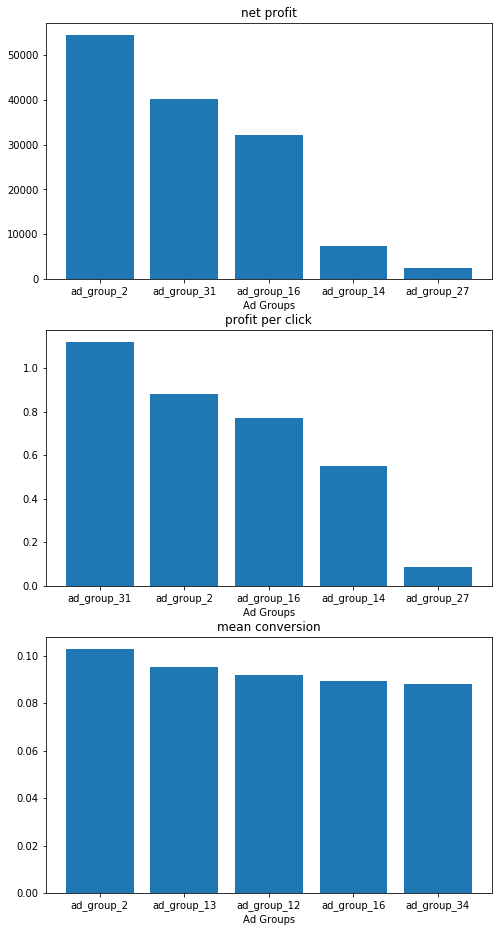

In [152]:
#Finally we plot the metrics for each ad group
fig, ax = plt.subplots(nrows=3,ncols=1,figsize= (8, 16))
dfs= [profit_group, profit_per_group, conversion_group]
metric_name = ["net profit", "profit per click", "mean conversion"]
def plot_metrics(metric_df, ind):
    groups = list(metric_df.index)
    vals = metric_df[metric_df.columns[0]]
    ax[ind].bar(groups,vals)
    ax[ind].set_xlabel("Ad Groups")
    ax[ind].set_title(metric_name[ind])
for i in range(len(dfs)):
    plot_metrics(dfs[i],i)

## Question 2
For each group, predict how many ads will be shown on Dec, 15 (assume each ad group keeps following its trend).

December 15 is 23 days from the last observation
So we utilize an ARIMA model to forecast each the number of ads shown for each ad group


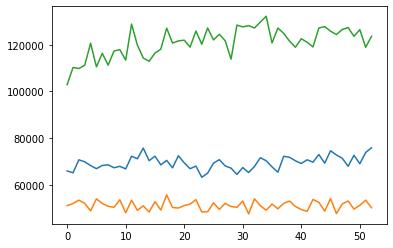

In [350]:
plt.plot(np.arange(53),ads[ads.ad == "ad_group_1"]["shown"].values)
plt.plot(np.arange(53),ads[ads.ad == "ad_group_2"]["shown"].values)
plt.plot(np.arange(53),ads[ads.ad == "ad_group_9"]["shown"].values)
#len(ads[ads.ad == "ad_group_4"]["shown"])

In [351]:
from statsmodels.tsa.arima.model import ARIMA
from random import random
def forecast_ads(df):
    data =  df["shown"].values
    model = ARIMA(data, order=(1, 2,1 ))
    model_fit = model.fit()
    yhat = model_fit.predict(0, len(data)+23, type='levels')
    df["forecast"] = yhat[-1]
    return df

In [352]:
forecasted_ads = ads.groupby("ad").apply(forecast_ads)

C:\Users\Levente\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## Question 3

Cluster ads into 3 groups: the ones whose avg_cost_per_click is going up, the ones whose avg_cost_per_click is flat and the ones whose avg_cost_per_click is going down.

1. First we need to attach a numeric value to Change in AVG cost per click for this we can use the slope from linear regression
2. Once we have the trends calculated we can then cluster them using some hard margin or an algorithm like Kmeans


In [353]:
aa = ads[ads.ad == "ad_group_1"]["avg_cost_per_click"].values
aa

array([0.9 , 0.94, 0.86, 1.01, 1.  , 0.98, 0.94, 1.07, 0.88, 0.93, 0.87,
       0.97, 1.14, 0.96, 0.81, 0.96, 1.12, 0.95, 0.97, 0.99, 0.97, 0.88,
       0.96, 0.96, 1.06, 0.89, 0.97, 1.08, 1.01, 0.96, 0.97, 0.95, 0.93,
       0.9 , 1.  , 0.96, 0.93, 0.85, 1.09, 0.96, 0.93, 1.05, 0.87, 1.02,
       1.01, 1.  , 1.01, 0.92, 1.09, 1.  , 1.08, 0.99, 0.98])

In [370]:
from sklearn.linear_model import LinearRegression
def percent_change_cost_per_click(df,plot=True):
    lg = LinearRegression()
    data = df["avg_cost_per_click"]
    lg.fit(np.arange(len(data)).reshape(-1,1), data)
    preds = lg.predict(np.arange(len(data)).reshape(-1,1))
    percent_increase = (preds[-1] - preds[0])/ preds[0]
    
    if plot:
        plt.plot(preds)
        print(percent_increase)
        plt.plot(np.arange(len(data)).reshape(-1,1), data)
        plt.show()
    df["percent_increase"] = percent_increase
    return df

Below we can see the linear regression and corresponding percentage change for a part of the dataset

0.05085983666423216


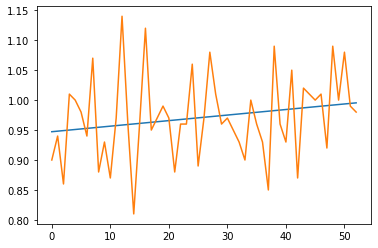

-0.0005255205938382941


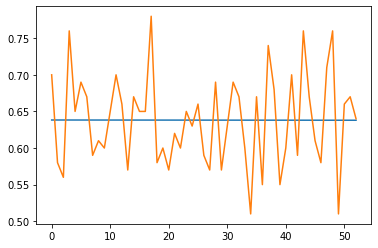

0.04854617650826182


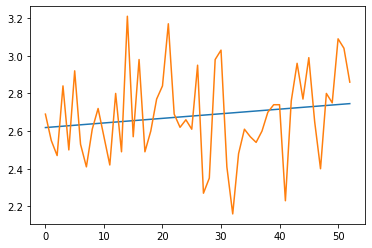

-0.008302821598225058


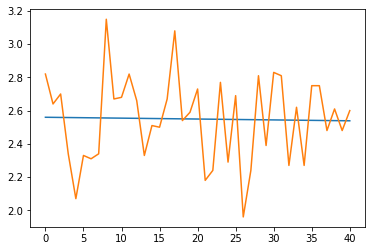

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,profit,percent_increase
0,10/1/15,65877,2339,43,0.90,641.62,ad_group_1,-1463.48,0.050860
1,10/2/15,65100,2498,38,0.94,756.37,ad_group_1,-1591.75,0.050860
2,10/3/15,70658,2313,49,0.86,970.90,ad_group_1,-1018.28,0.050860
3,10/4/15,69809,2833,51,1.01,907.39,ad_group_1,-1953.94,0.050860
4,10/5/15,68186,2696,41,1.00,879.45,ad_group_1,-1816.55,0.050860
...,...,...,...,...,...,...,...,...,...
195,11/6/15,97299,8679,497,2.75,5122.17,ad_group_4,-18745.08,-0.008303
196,11/7/15,92297,7954,554,2.48,14174.00,ad_group_4,-5551.92,-0.008303
197,11/8/15,89455,8518,365,2.61,6793.77,ad_group_4,-15438.21,-0.008303
198,11/9/15,94671,7557,545,2.48,9370.20,ad_group_4,-9371.16,-0.008303


In [371]:
ads.iloc[:200].groupby("ad").apply(percent_change_cost_per_click)

In [373]:
ads = ads.groupby("ad").apply(percent_change_cost_per_click, plot = False)

In [461]:
percent_increases = ads[["ad","percent_increase"]].groupby("ad").mean("percent_increase")
ar = pd.DataFrame(ads.groupby("ad").mean("percent_increase")["percent_increase"])
ar = ar.sort_values(by="percent_increase")
#ar = np.digitize(ar,np.linspace(0,max(ar),3))

Binning the percent increase in this way does not equally split the values. The next way we could cluster the values in a more
relevant way would be to designate   
-5% <=percent_increase<=5% as flat

with >5% as increasing 

and <5% as decreasing in cost

In [464]:
def cluster_percent_change(df):
    if (df["percent_increase"].unique()[0] <= 0.05) & (df["percent_increase"].unique()[0]>= -0.05):
        df["cost_per_click_cluster"] = 0
    elif df["percent_increase"].unique()[0] > 0.05 :
        df["cost_per_click_cluster"] = 1
    else:
        df["cost_per_click_cluster"] = -1 
    return df

In [482]:
#We can see some of the clusters below
cluster = ads.groupby("ad").apply(cluster_percent_change).groupby("ad").mean("cost_per_click_cluster")
cluster = pd.DataFrame(cluster["cost_per_click_cluster"])
cluster.iloc[:10]

,cost_per_click_cluster
ad,
ad_group_1,1.0
ad_group_10,0.0
ad_group_11,-1.0
ad_group_12,-1.0
ad_group_13,0.0
ad_group_14,-1.0
ad_group_15,0.0
ad_group_16,0.0
ad_group_17,0.0


We can see our cluster breakdown by applying the cluster_percent_change function and then grouping by the cluster

Text(0.5, 1.0, 'Count of Clusters')

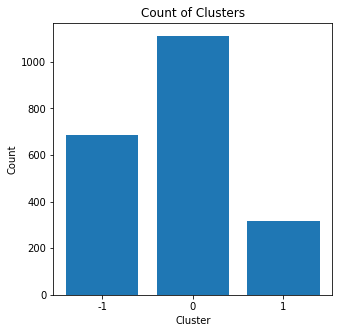

In [470]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(5,5))
cluster = ads.groupby("ad").apply(cluster_percent_change).groupby("cost_per_click_cluster").size()
ax.bar(list(map(str,cluster.index)), cluster.values)
ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
ax.set_title("Count of Clusters")

## Summary

1. We identified the best ad groups through 3 different metrics, net profit, profit per click and conversion rate 

2. We predicted the number of ads shown on Dec. 15 for each ad group using an ARIMA models (the performance of which could be improved upon using better hyperparameter selection)

3. Finally we clustered the ad groups according to the percent change in average cost per click. To do this we first implemented a linear regression, which allowed us to estimate the percent change in cost per click over the given period. The percent change was then clustered according to a hard margin, with flat values designated as having a %change within [-0.5,0.5]
